<a href="https://colab.research.google.com/github/smomtahe/GANs_Generative-Adversarial-Networks/blob/main/Cycle_GANs_MultiChannel_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Deep Convolutional GANs work on multichannel : color images with RGB values for pixels

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os
import time
# Assuming /content/images contains face images
batch_size = 32
epochs = 50

In [ ]:
os.getcwd()

'/content'

In [ ]:
#!unzip -q '/content/images.zip' -d /content/

In [ ]:
!ls /content

images	images.zip  sample_data


In [ ]:
batch_size = 32
train_dataset_faces = image_dataset_from_directory(
    '/content/images', label_mode=None, image_size=(64, 64), batch_size=batch_size
).map(lambda x: (x - 127.5) / 127.5)

# Load CIFAR-10 and select bird images
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
x_train_birds = x_train[y_train.flatten() == 2]
x_train_birds = tf.image.resize(x_train_birds, (64, 64))
x_train_birds = (x_train_birds - 127.5) / 127.5
train_dataset_birds = tf.data.Dataset.from_tensor_slices(x_train_birds).batch(batch_size)


Found 6724 files belonging to 1 classes.


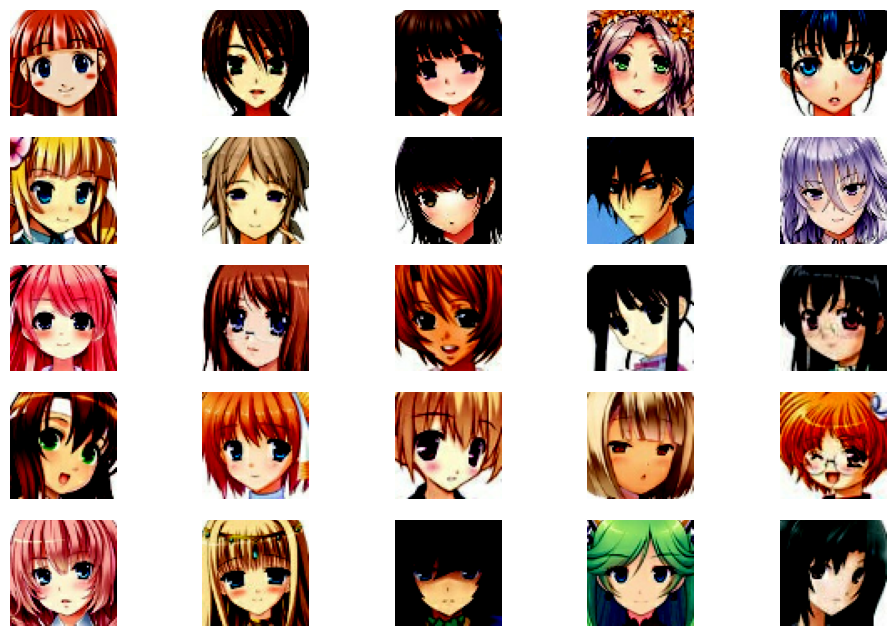

In [ ]:
plt.figure(figsize=(12,8))
for images in train_dataset_faces.take(1):
  for i in range(25): # extract 1st 25 images from the 1st batch in the training dataset
    ax=plt.subplot(5,5,i+1)
    plt.imshow(images[i].numpy())
    plt.axis('off')

# each img is 64*64 multichannel

Image_shape (64, 64, 3)


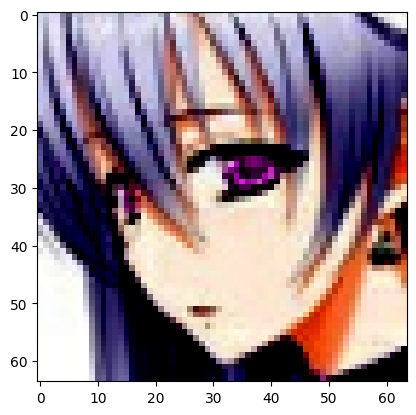

In [ ]:
for batch in train_dataset_faces:
  plt.imshow(batch[0])
  print('Image_shape',batch[0].shape)
  break

In [ ]:
init = RandomNormal(mean=0.0, stddev=0.02)

def make_generator_model():
    inputs = Input(shape=(64, 64, 3))
    # Define your generator network
    # This is a simplified structure
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    # Add more layers as needed...
    x = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh', kernel_initializer=init)(x)
    return Model(inputs, x, name='generator')

def make_discriminator_model():
    inputs = Input(shape=(64, 64, 3))
    # Define your discriminator network
    # This is a simplified structure
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    # Add more layers as needed...
    x = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(x)
    return Model(inputs, x, name='discriminator')

# Build two generators and two discriminators for the CycleGAN
G_faces_to_birds = make_generator_model()
G_birds_to_faces = make_generator_model()
D_faces = make_discriminator_model()
D_birds = make_discriminator_model()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# Initialize the generator
generator = make_generator_model()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 64, 64, 3)         3075      
 Transpose)                                                      
                                                                 
Total params: 6211 (24.26 KB)
Trainable params: 6211 (24.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def generator_loss_fn(disc_generated_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)

def discriminator_loss_fn(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def cycle_consistency_loss_fn(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

In [ ]:
G_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
D_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
lambda_cycle = 10.0  # Weight for cycle consistency loss

@tf.function
def train_step(real_faces, real_birds):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        fake_birds = G_faces_to_birds(real_faces, training=True)
        cycled_faces = G_birds_to_faces(fake_birds, training=True)

        fake_faces = G_birds_to_faces(real_birds, training=True)
        cycled_birds = G_faces_to_birds(fake_faces, training=True)

        # Discriminator output
        disc_real_faces = D_faces(real_faces, training=True)
        disc_real_birds = D_birds(real_birds, training=True)
        disc_fake_faces = D_faces(fake_faces, training=True)
        disc_fake_birds = D_birds(fake_birds, training=True)

        # Generator adversarial loss
        gen_faces_loss = generator_loss_fn(disc_fake_faces)
        gen_birds_loss = generator_loss_fn(disc_fake_birds)

        # Total cycle consistency loss
        total_cycle_loss = cycle_consistency_loss_fn(real_faces, cycled_faces) + cycle_consistency_loss_fn(real_birds, cycled_birds)

        # Total generator loss
        total_gen_faces_loss = gen_faces_loss + (lambda_cycle * total_cycle_loss)
        total_gen_birds_loss = gen_birds_loss + (lambda_cycle * total_cycle_loss)

        # Discriminator loss
        disc_faces_loss = discriminator_loss_fn(disc_real_faces, disc_fake_faces)
        disc_birds_loss = discriminator_loss_fn(disc_real_birds, disc_fake_birds)

    # Calculate the gradients for generators and discriminators
    G_faces_gradients = tape.gradient(total_gen_faces_loss, G_faces_to_birds.trainable_variables)
    G_birds_gradients = tape.gradient(total_gen_birds_loss, G_birds_to_faces.trainable_variables)

    D_faces_gradients = tape.gradient(disc_faces_loss, D_faces.trainable_variables)
    D_birds_gradients = tape.gradient(disc_birds_loss, D_birds.trainable_variables)

    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_faces_gradients, G_faces_to_birds.trainable_variables))
    G_optimizer.apply_gradients(zip(G_birds_gradients, G_birds_to_faces.trainable_variables))
    D_optimizer.apply_gradients(zip(D_faces_gradients, D_faces.trainable_variables))
    D_optimizer.apply_gradients(zip(D_birds_gradients, D_birds.trainable_variables))


In [ ]:
import matplotlib.pyplot as plt

def plot_generated_images(epoch, real_image, generated_image):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Real Image')
    plt.imshow(real_image * 0.5 + 0.5)  # Assuming images are normalized [-1, 1]
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Generated Image')
    plt.imshow(generated_image * 0.5 + 0.5)  # Assuming images are normalized [-1, 1]
    plt.axis('off')

    plt.suptitle(f'Epoch {epoch+1}')
    plt.show()

In [ ]:
# Adjusting the sampling to ensure we're working with single images
sample_face = sample_faces[0]  # Selecting the first image from the batch
sample_bird = sample_birds[0]  # Selecting the first image from the batch

# Then, when generating fake images, ensure you're adding the batch dimension correctly
fake_bird = G_faces_to_birds(sample_face[None, ...], training=False)
fake_face = G_birds_to_faces(sample_bird[None, ...], training=False)

# Since now `sample_face` and `sample_bird` are single images, the rest of your code should work as intended


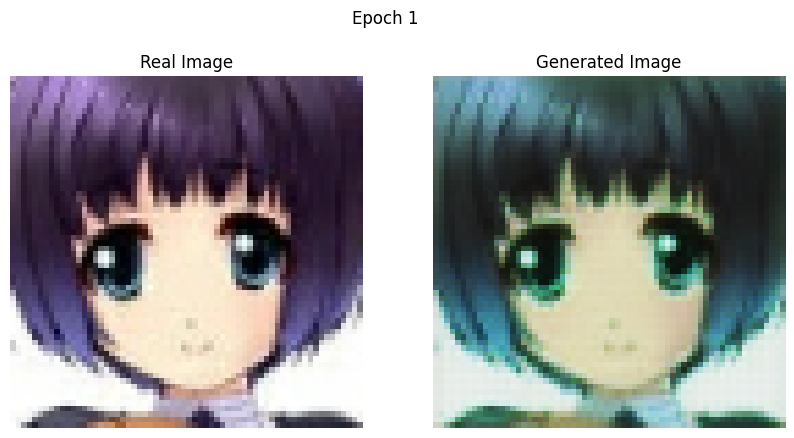

Time for epoch 1 is 2.189160108566284 sec


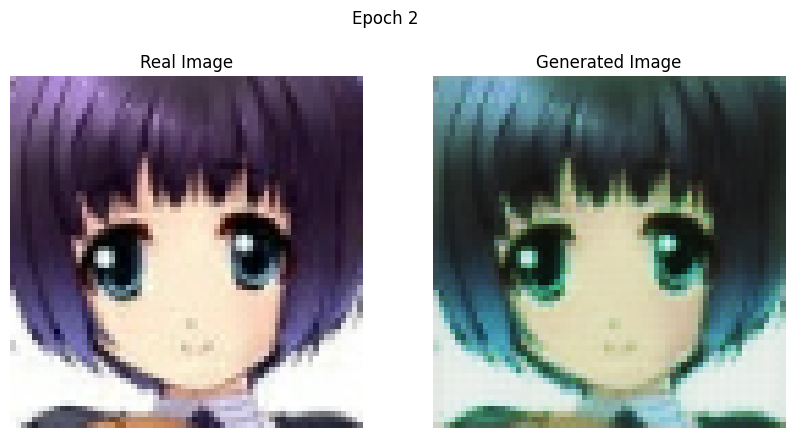

Time for epoch 2 is 2.0995070934295654 sec


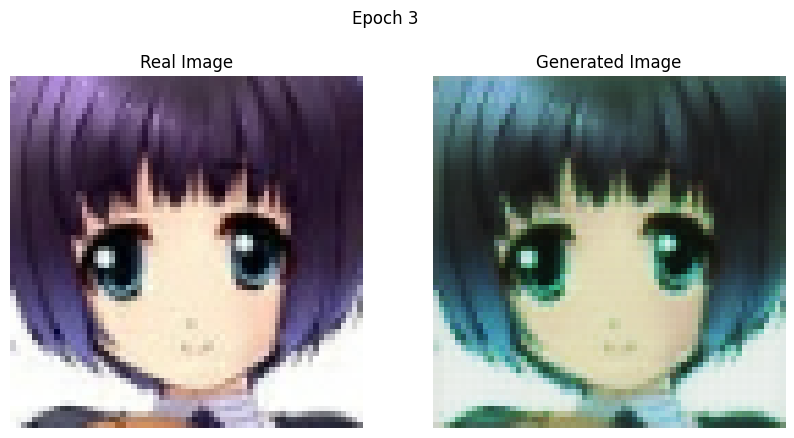

Time for epoch 3 is 2.2895350456237793 sec


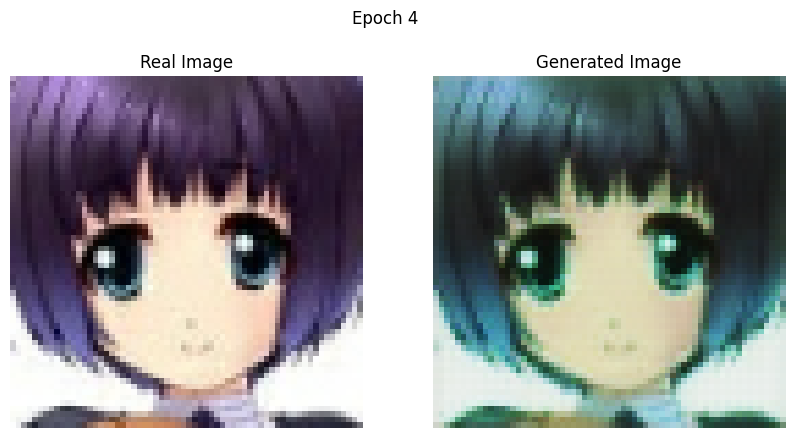

Time for epoch 4 is 3.346867799758911 sec


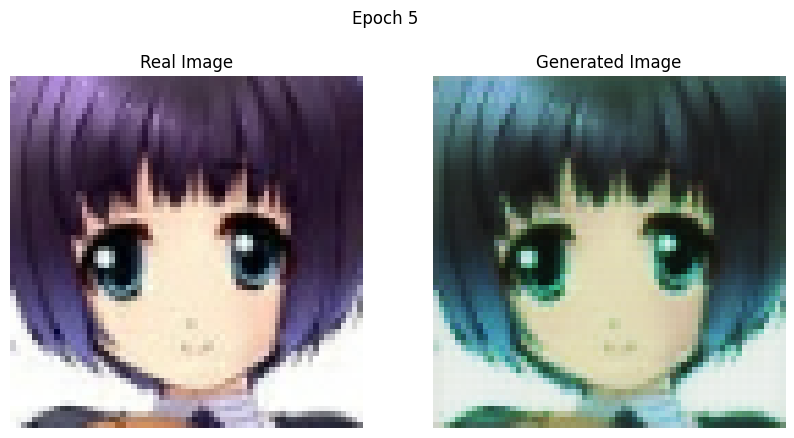

Time for epoch 5 is 2.5075769424438477 sec


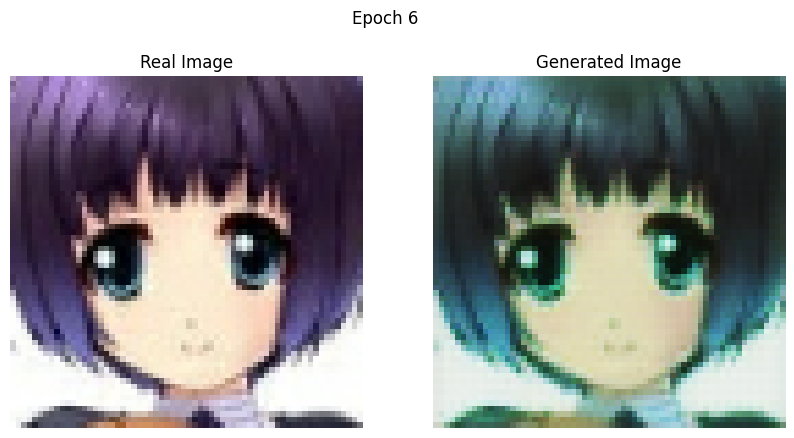

Time for epoch 6 is 2.423016309738159 sec


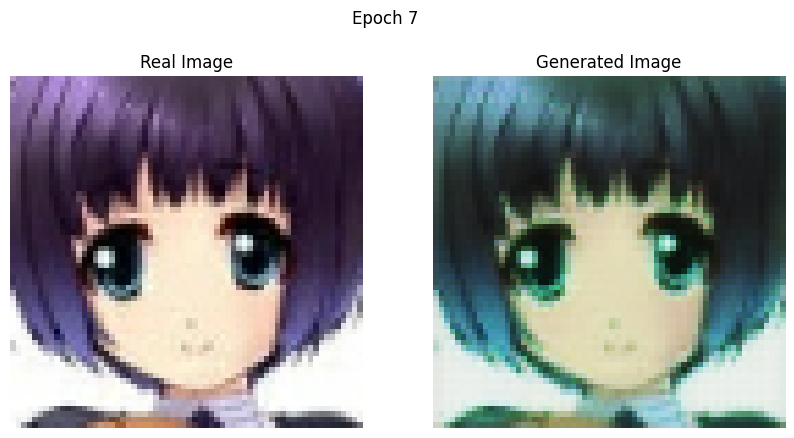

Time for epoch 7 is 2.610351800918579 sec


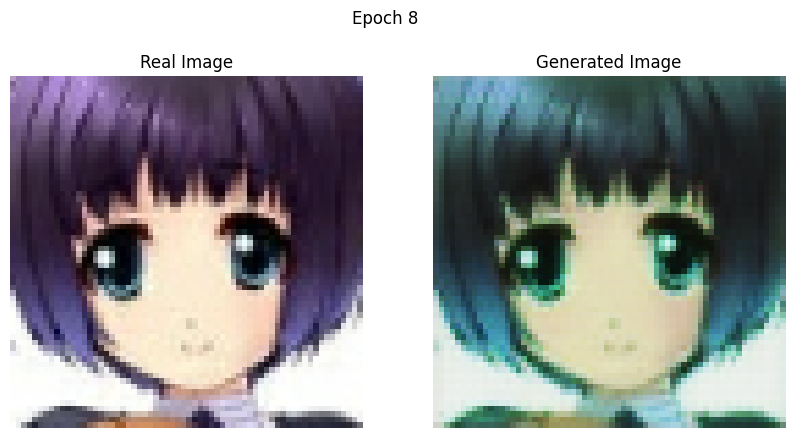

Time for epoch 8 is 2.6611251831054688 sec


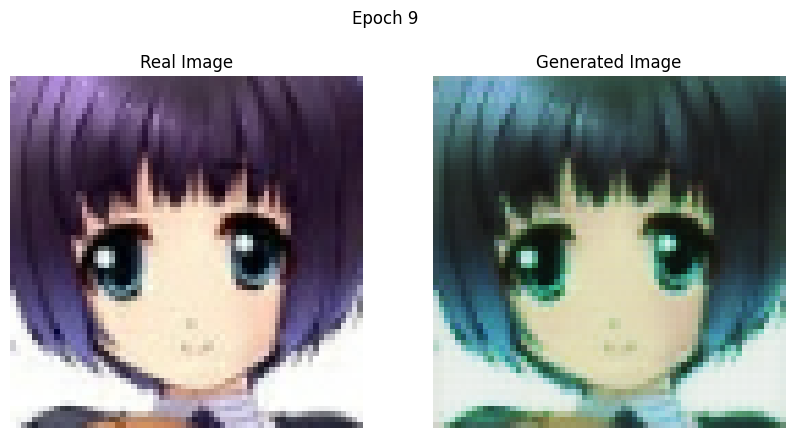

Time for epoch 9 is 2.840296983718872 sec


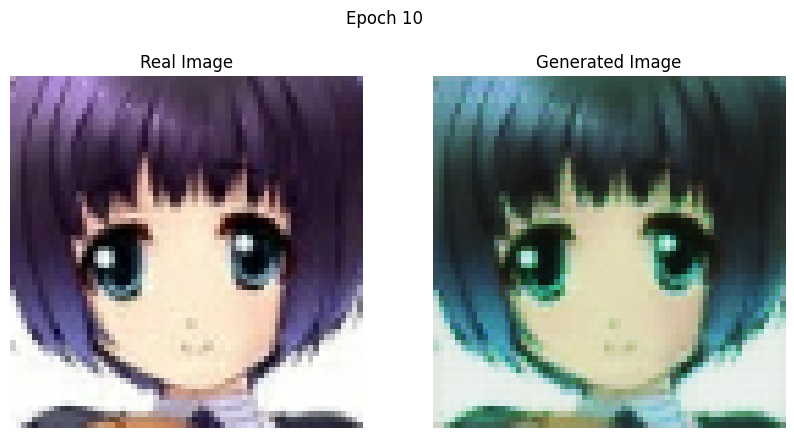

Time for epoch 10 is 2.4936158657073975 sec


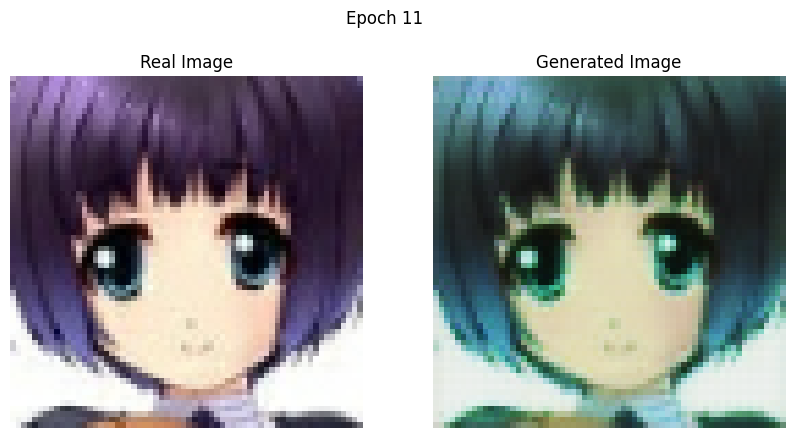

Time for epoch 11 is 2.1553807258605957 sec


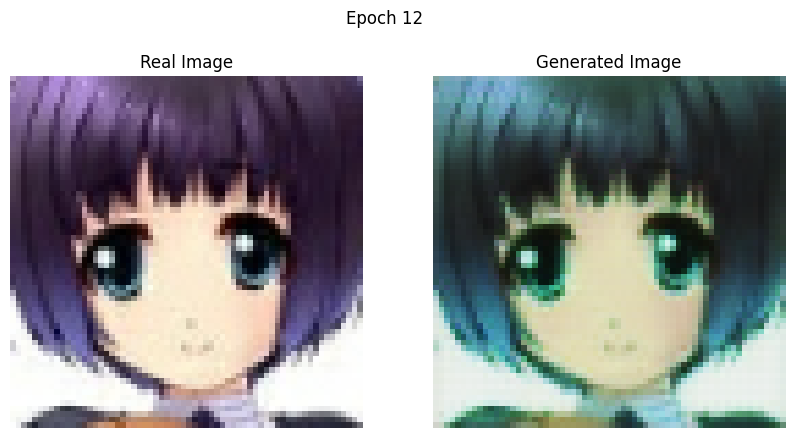

Time for epoch 12 is 2.1416614055633545 sec


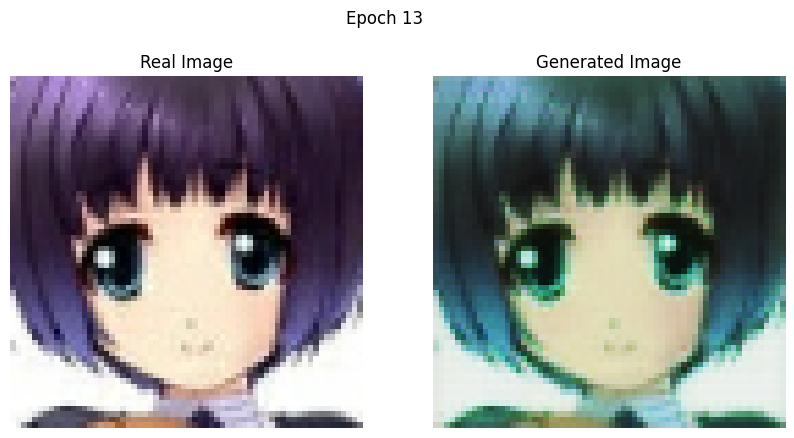

Time for epoch 13 is 2.1362762451171875 sec


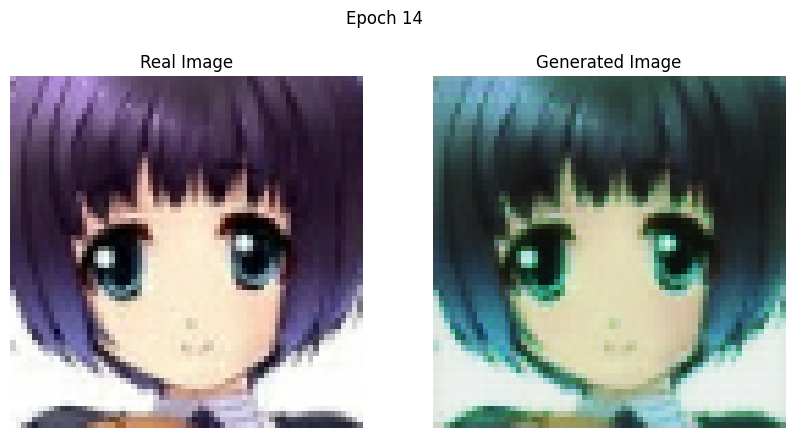

Time for epoch 14 is 2.4978978633880615 sec


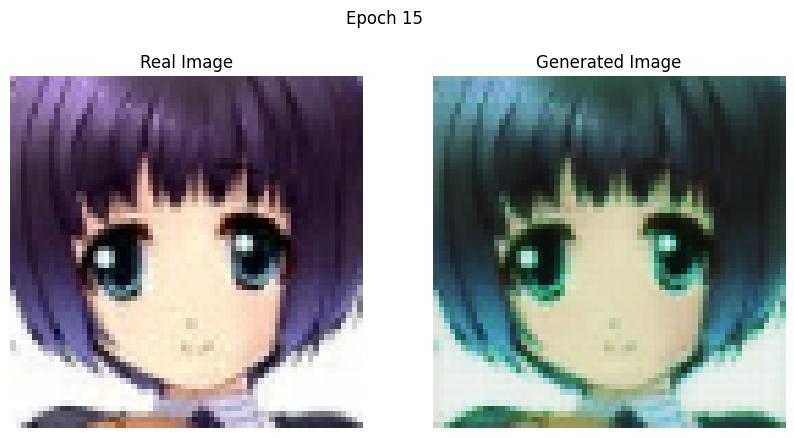

Time for epoch 15 is 2.635526657104492 sec


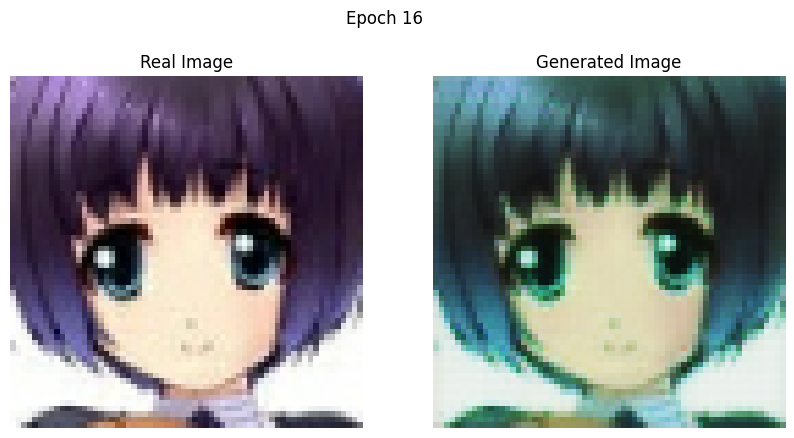

Time for epoch 16 is 2.147477149963379 sec


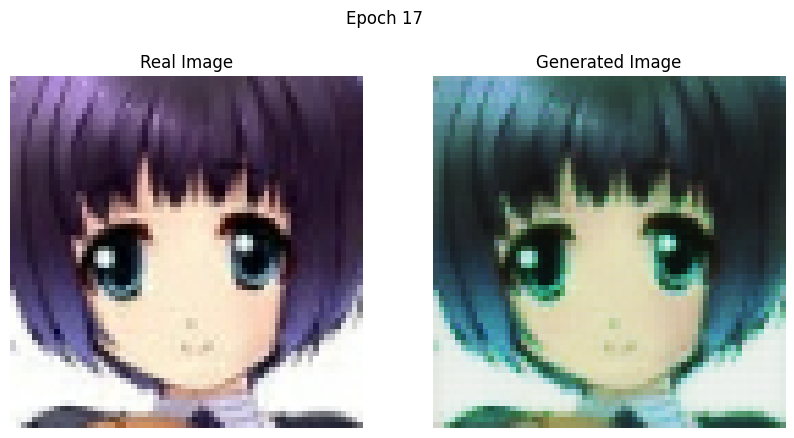

Time for epoch 17 is 2.4325082302093506 sec


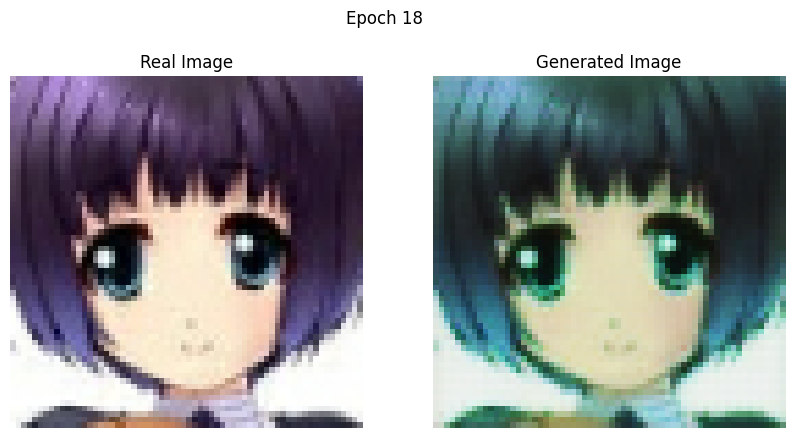

Time for epoch 18 is 2.1645498275756836 sec


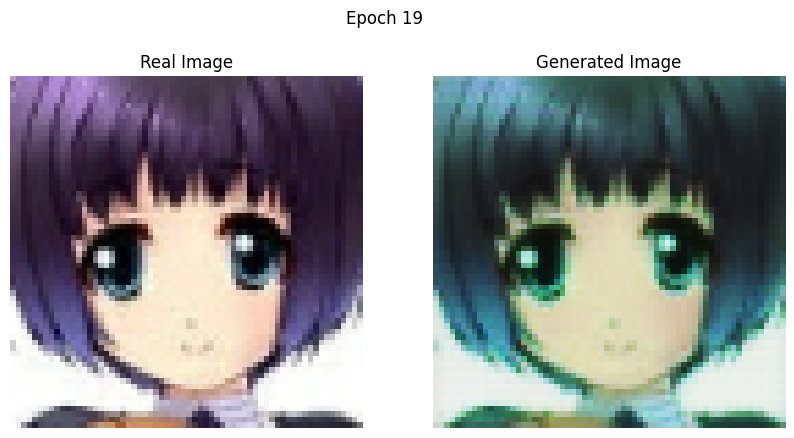

Time for epoch 19 is 2.1959621906280518 sec


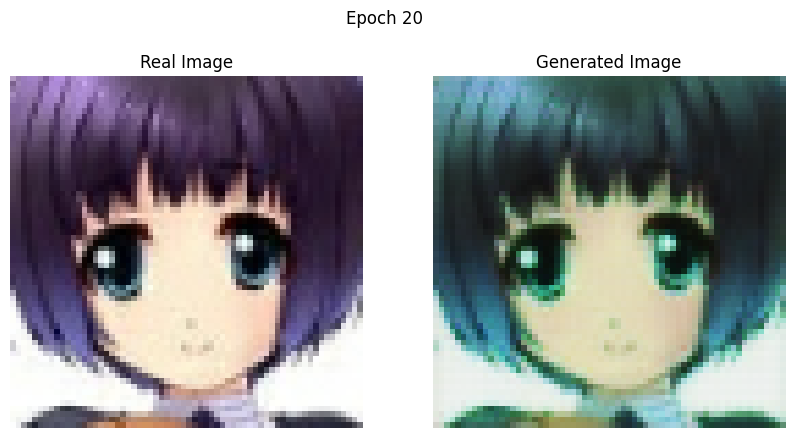

Time for epoch 20 is 2.909013271331787 sec


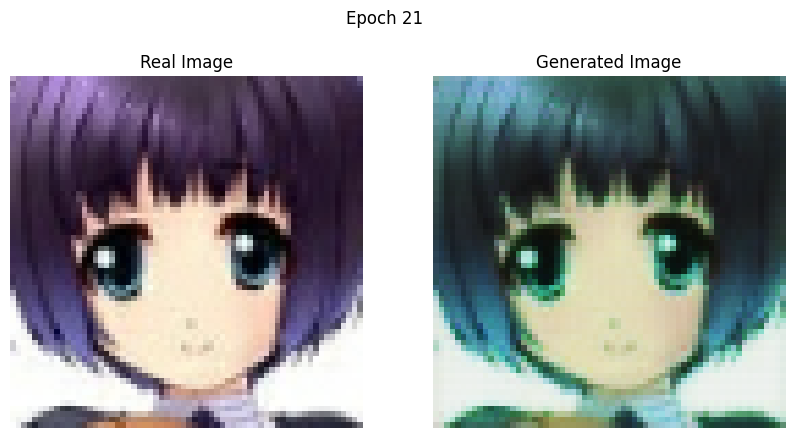

Time for epoch 21 is 2.373438835144043 sec


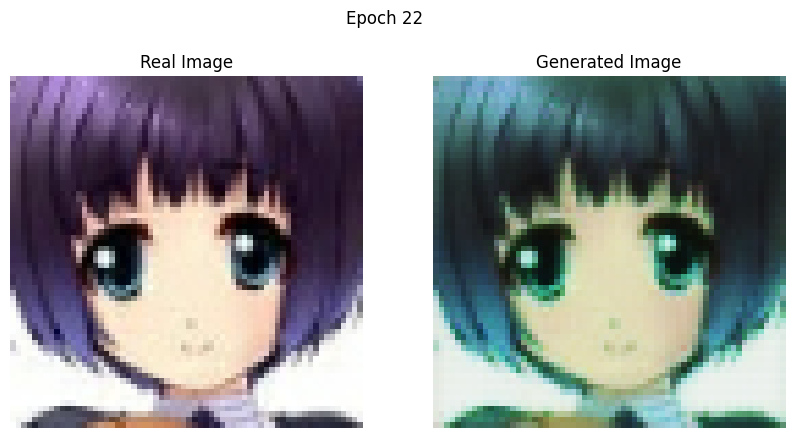

Time for epoch 22 is 2.2009329795837402 sec


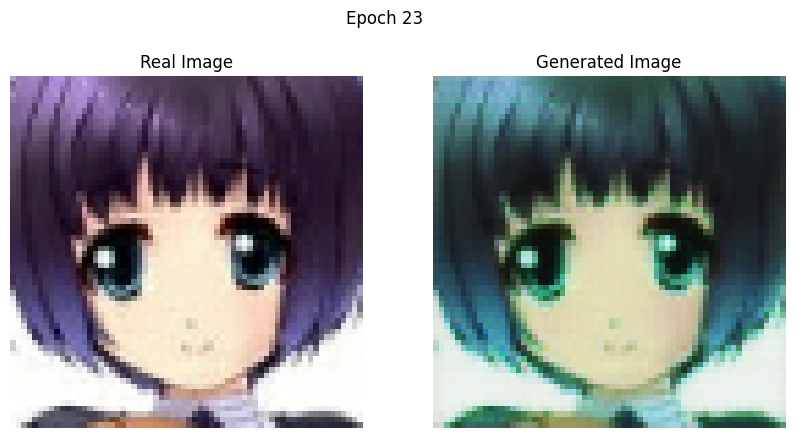

Time for epoch 23 is 2.182171106338501 sec


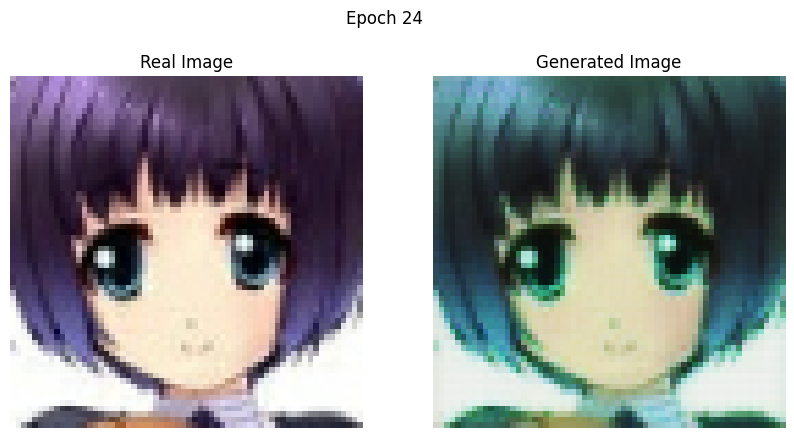

Time for epoch 24 is 2.1886985301971436 sec


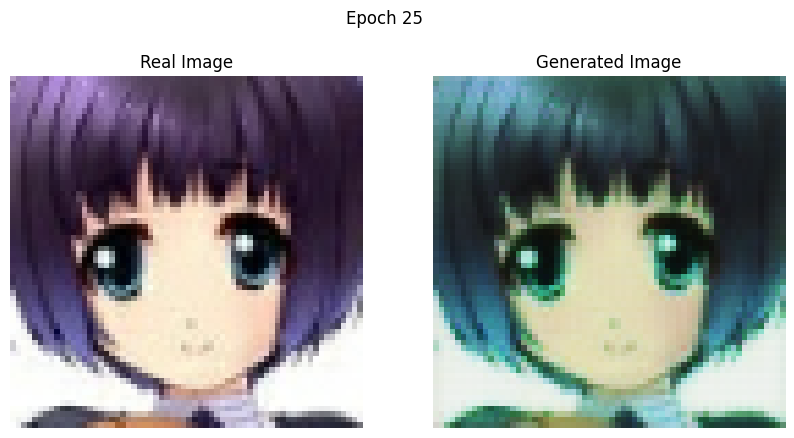

Time for epoch 25 is 2.336205005645752 sec


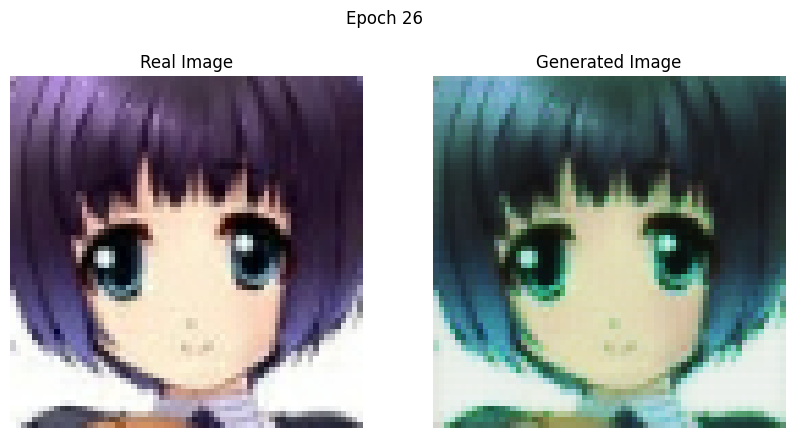

Time for epoch 26 is 2.849154472351074 sec


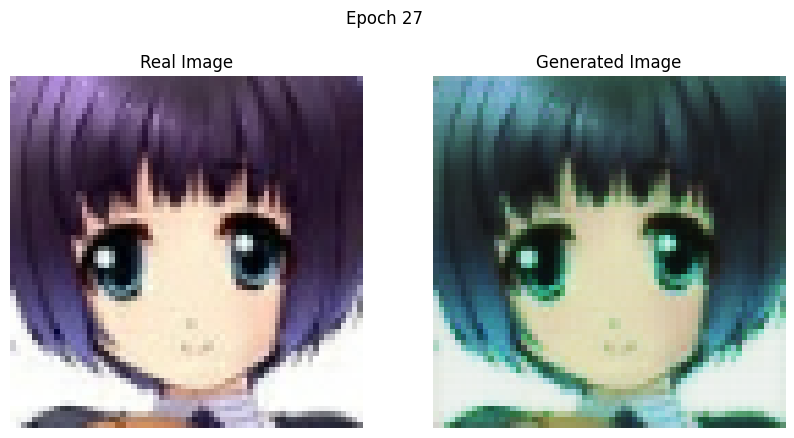

Time for epoch 27 is 2.191391706466675 sec


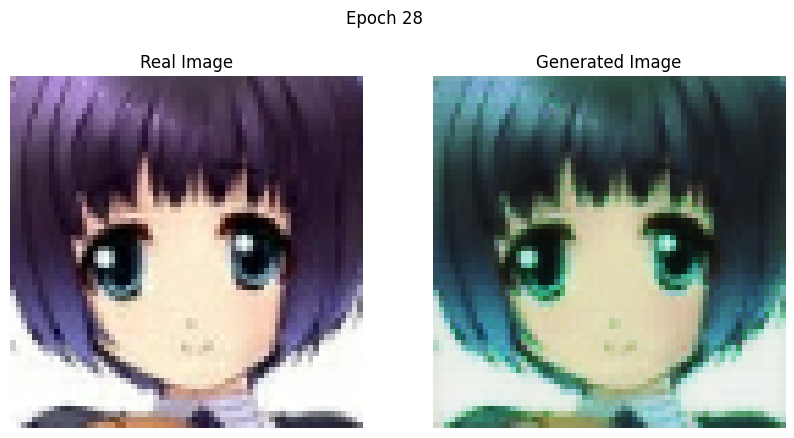

Time for epoch 28 is 2.2055203914642334 sec


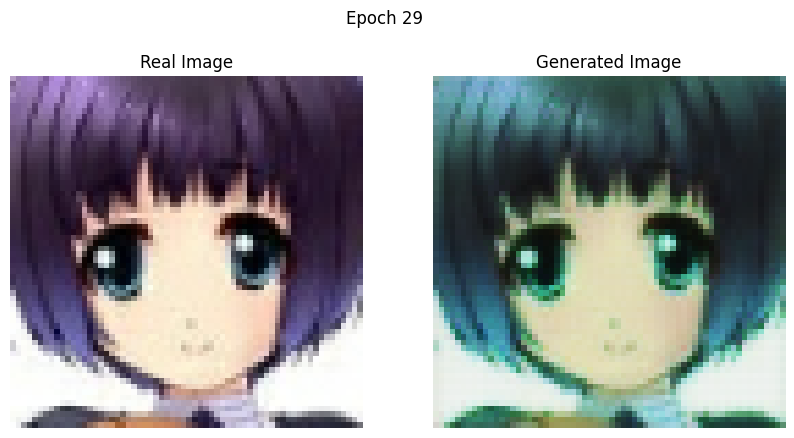

Time for epoch 29 is 2.211718797683716 sec


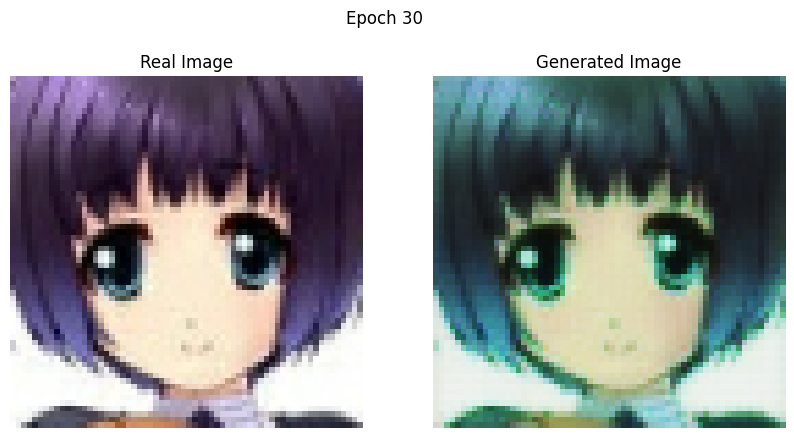

Time for epoch 30 is 2.2034788131713867 sec


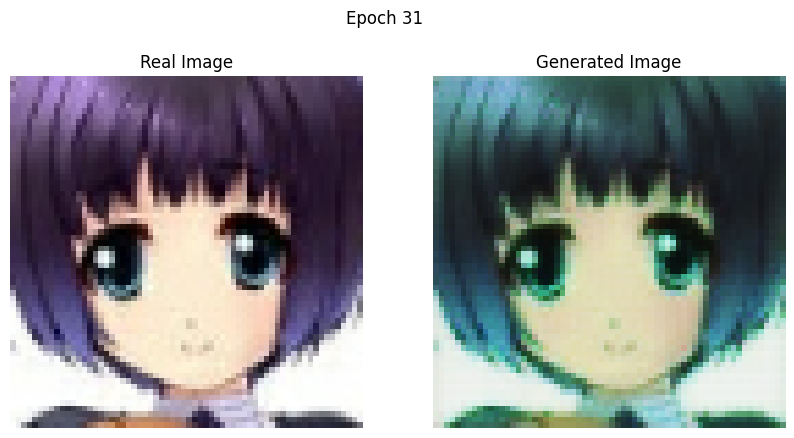

Time for epoch 31 is 2.554347038269043 sec


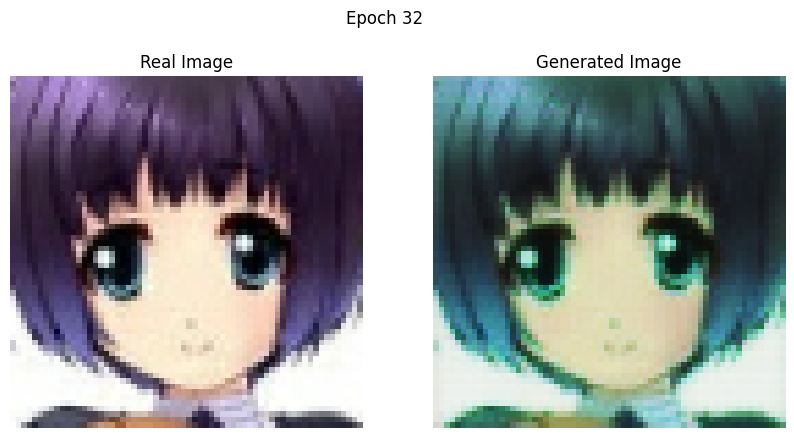

Time for epoch 32 is 2.698976993560791 sec


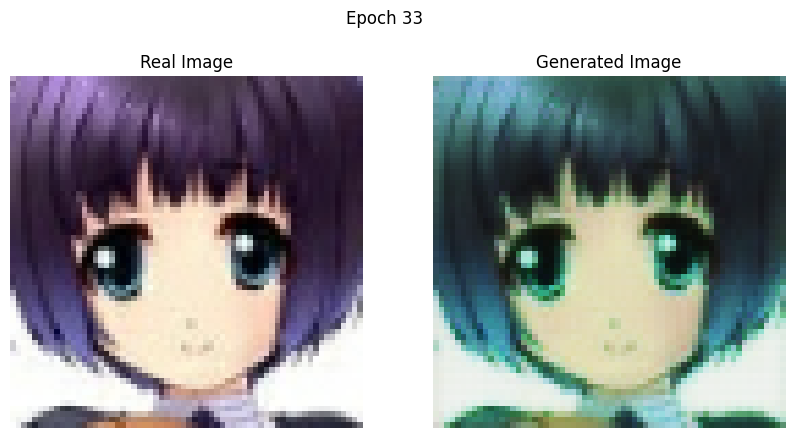

Time for epoch 33 is 2.2313456535339355 sec


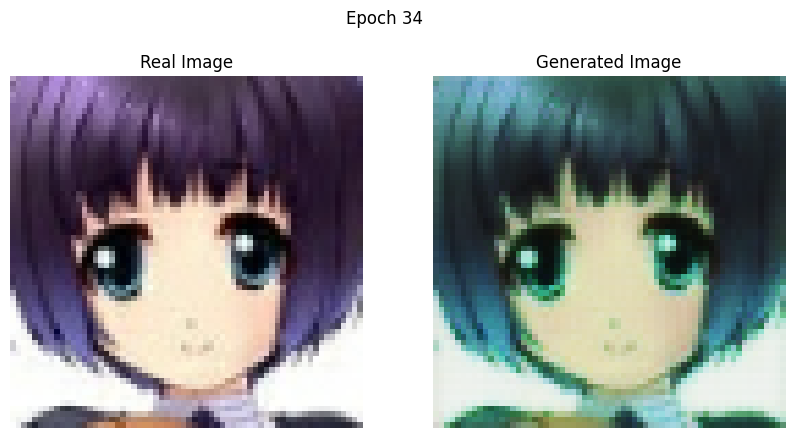

Time for epoch 34 is 2.2352888584136963 sec


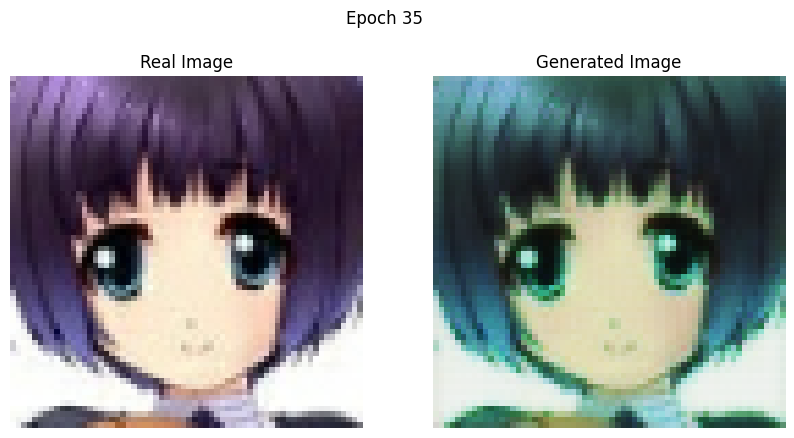

Time for epoch 35 is 2.2280068397521973 sec


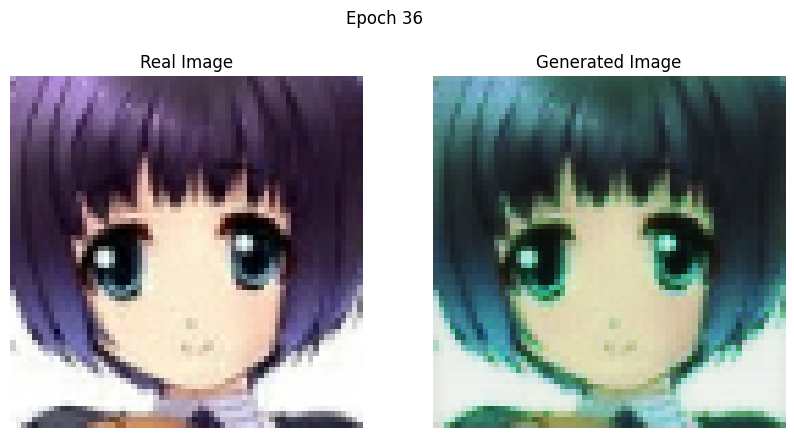

Time for epoch 36 is 2.281008243560791 sec


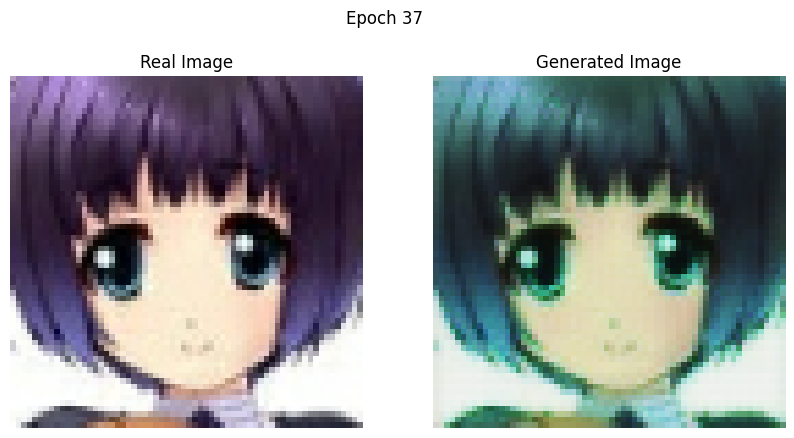

Time for epoch 37 is 2.88740611076355 sec


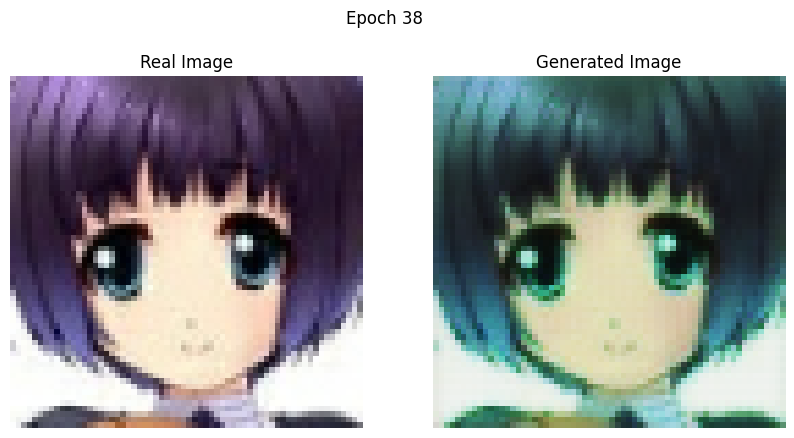

Time for epoch 38 is 2.347287654876709 sec


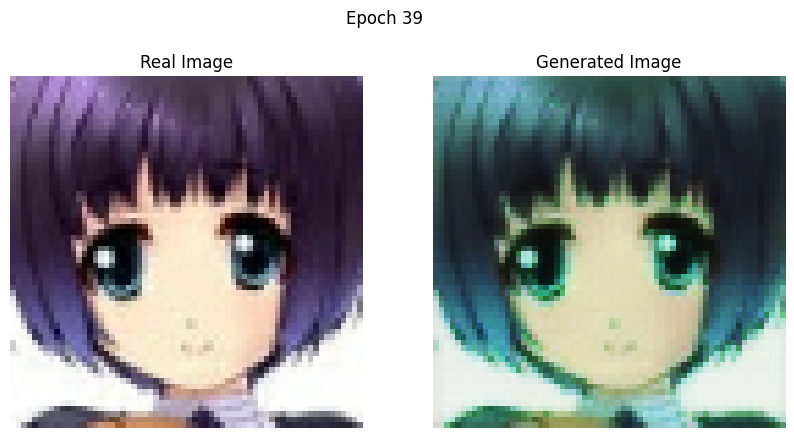

Time for epoch 39 is 2.6054913997650146 sec


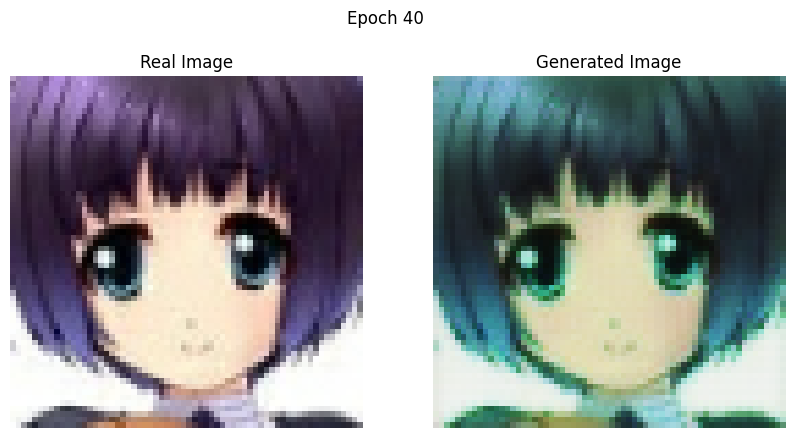

Time for epoch 40 is 2.211507558822632 sec


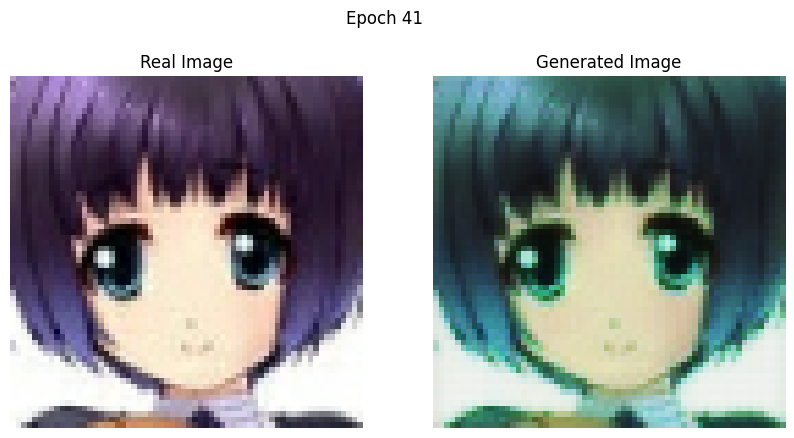

Time for epoch 41 is 2.221630096435547 sec


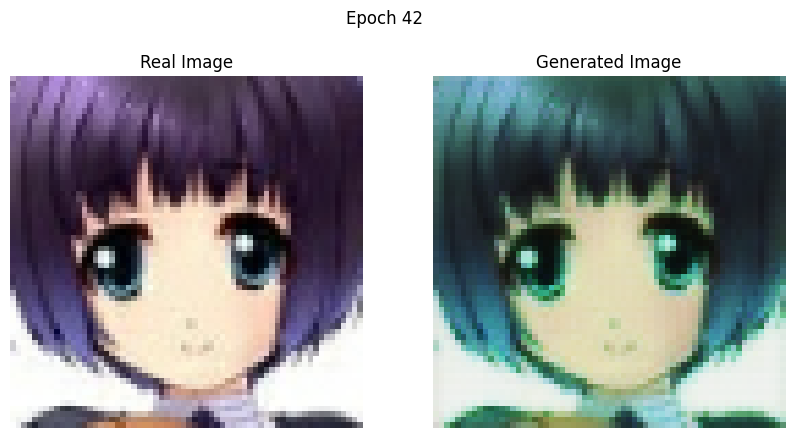

Time for epoch 42 is 2.5427534580230713 sec


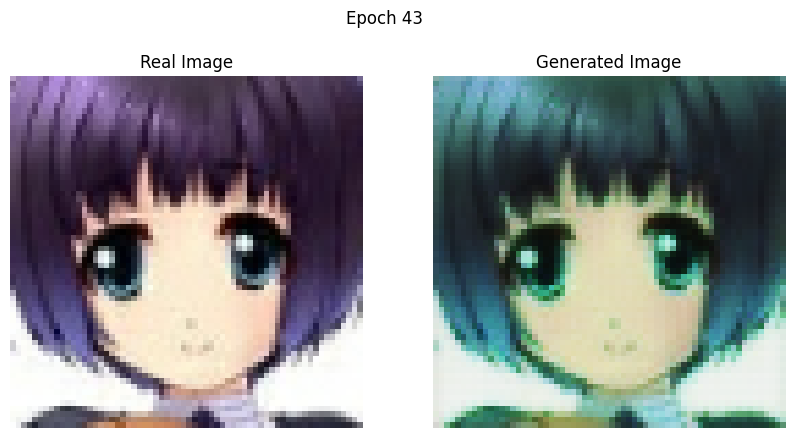

Time for epoch 43 is 2.6987574100494385 sec


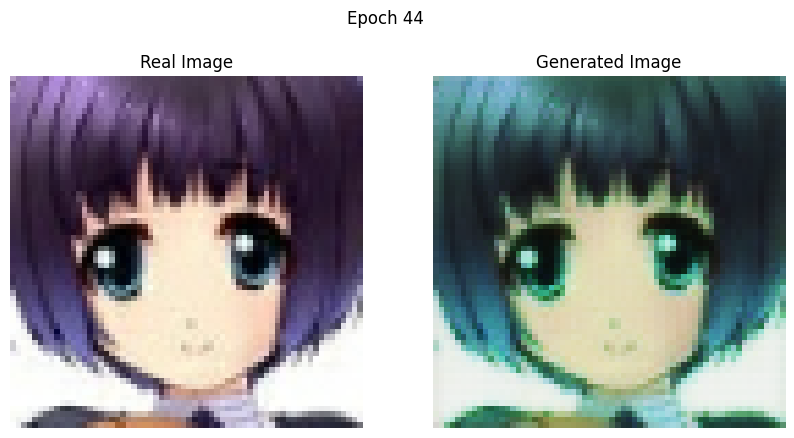

Time for epoch 44 is 2.2074134349823 sec


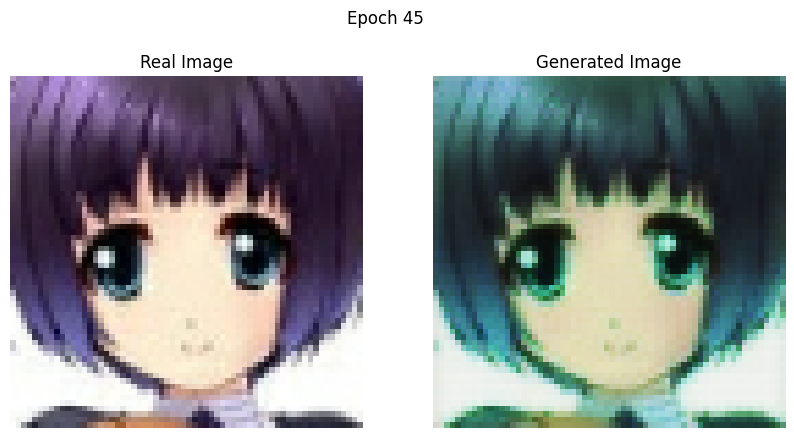

Time for epoch 45 is 2.790578842163086 sec


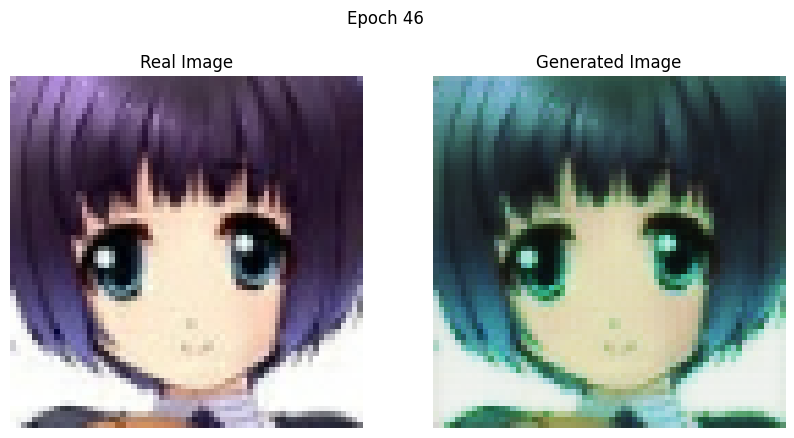

Time for epoch 46 is 2.4142138957977295 sec


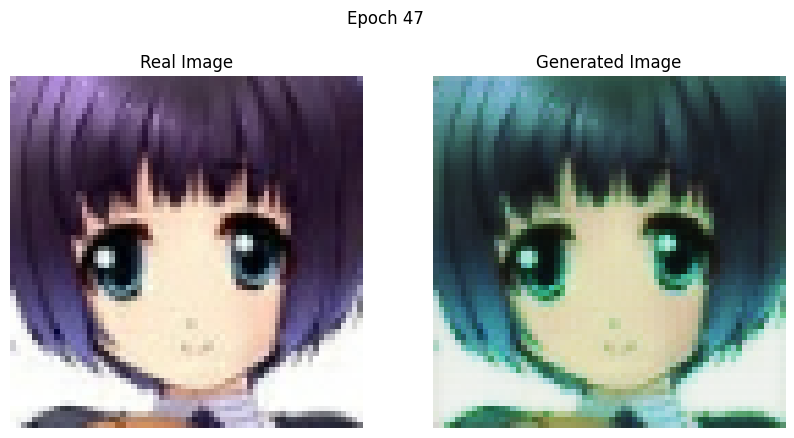

Time for epoch 47 is 2.3001959323883057 sec


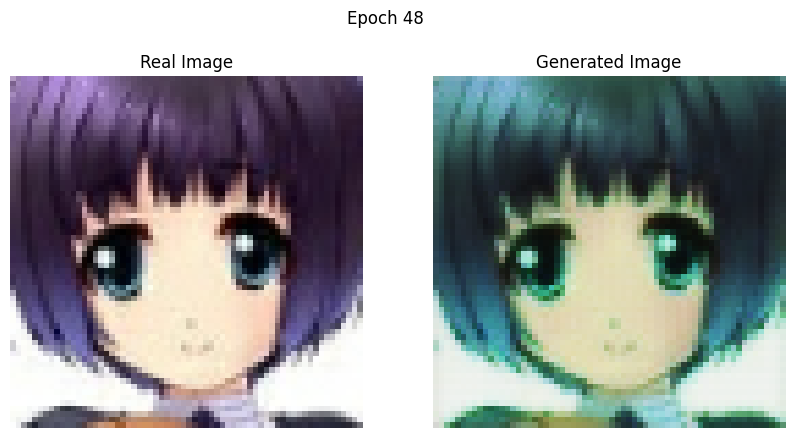

Time for epoch 48 is 2.9322941303253174 sec


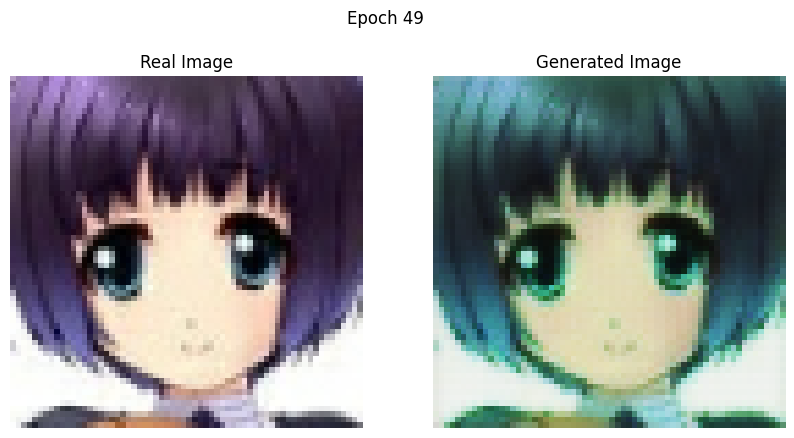

Time for epoch 49 is 2.2194032669067383 sec


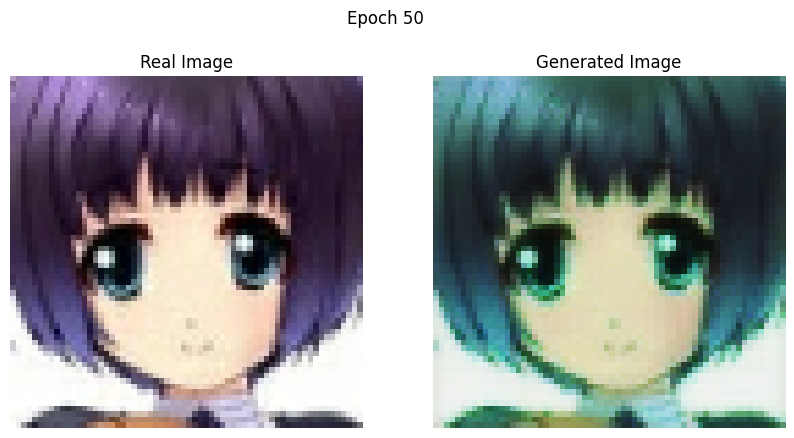

Time for epoch 50 is 2.213700294494629 sec


In [ ]:
epochs = 50  # Adjust based on observation during training

# Assuming you have a way to fetch a single sample for visualization purposes
for sample_faces, sample_birds in tf.data.Dataset.zip((train_dataset_faces.take(1), train_dataset_birds.take(1))):
    # Extracting a single image from the batch for both faces and birds
    sample_face = sample_faces[0]  # Assuming this gives a single sample image
    sample_bird = sample_birds[0]  # Assuming this gives a single sample image

for epoch in range(epochs):
    start = time.time()

    for real_faces, real_birds in tf.data.Dataset.zip((train_dataset_faces, train_dataset_birds)):
        train_step(real_faces, real_birds)

    # Adjust the generation and plotting code as per the corrected approach
    fake_bird = G_faces_to_birds(sample_face[None, ...], training=False)
    fake_face = G_birds_to_faces(sample_bird[None, ...], training=False)

    # Plotting the generated images
    plot_generated_images(epoch, sample_face, fake_bird[0])

    print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')
